In [1]:
# Parameters
name = "Ar_III-7136_mask_bin_4"
data = "Orion Ar"


In [2]:
# Parameters
#name = "H_I-6563_mask_bin_4"
#data = "Orion Ha"


In [3]:
import time
start_time = time.time()
import sys
import lmfit
import json
import corner
import emcee
from pathlib    import Path
from matplotlib import pyplot as plt
import cmasher as cmr
import numpy   as np
import seaborn as sns
import pandas  as pd

In [4]:
name_ = data
Path("Imgs").mkdir(parents=True, exist_ok=True)

sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules")
sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse")

# Add path to py_modules 
#sys.path.append(str(Path().resolve().parents[0] / 'py_modules')) # 1 level up = project root

# Add path to pipeline_config.py
#sys.path.append(str(Path().resolve().parents[0]))  # 1 level up = project root

# Import from pipeline_config and py_modules
from pipeline_config import STRUCTURE_DIR, RESULTS_DIR, CONFIDENCE_DIR


import bplot
import bfunc

In [5]:
# This should have been generated by notebook_template_mask
input_path = STRUCTURE_DIR / f"{name}.json"

with open(input_path) as f:
    data_in = json.load(f)

Data load and region parameters

In [6]:
mask = np.array(data_in["SF"]["N pairs"]) > 0

In [7]:
B = np.array(data_in["b2"])[mask]
r = np.array(data_in["s"])[mask]
pc = np.array(data_in["pc"])
pix = np.array(data_in["pix"])
box_size = np.array(data_in["box_size"])
pc_per_arcsec = pc

In [8]:
# Merge first K points
K = 3
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

In [9]:
model = lmfit.Model(bfunc.bfunc03s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [10]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2.0 * box_size)

# sig2 between 1/4 and 2 x max value of B(r) MOD
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.15 * B.max(), max=2.0 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec MOD
model.set_param_hint(
    "s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=2.5 * pc_per_arcsec
)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
# model.set_param_hint("box_size", value=box_size, vary=False)

In [11]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise
value,0.061079,10.464365,1.0,0.000994,0.501007
min,0.006108,3.139310,0.5,0.000199,0.000000
max,1.221588,41.857460,2.0,0.004969,3.006041


In [12]:
relative_uncertainty = 0.125
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5* box_size
#weights[large_scale] /= 1.25
#weights[:1] /= 2.0

In [13]:
to_fit = r <= 0.85 * box_size
#to_fit = ~large_scale
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [14]:
result

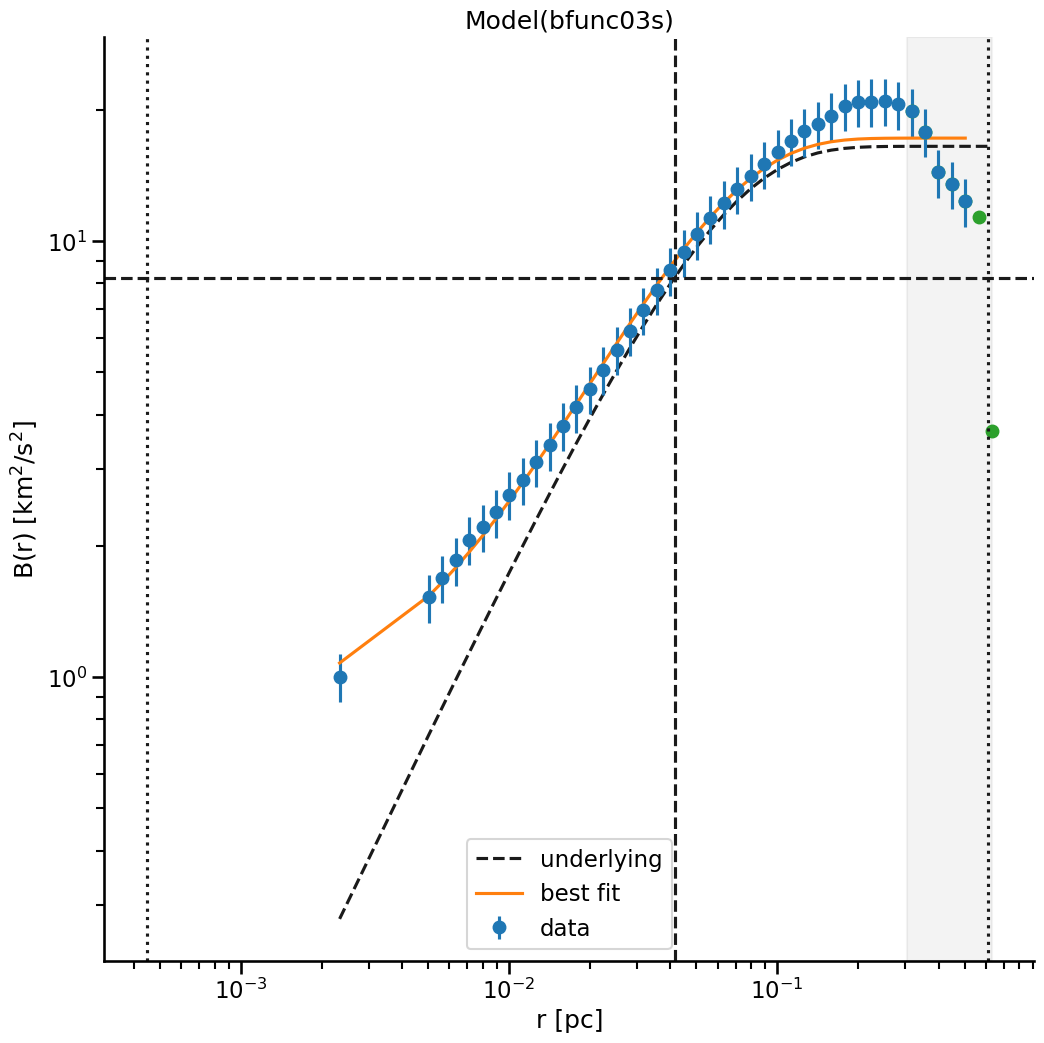

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(
    r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value
)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(box_size, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(box_size / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [pc]",
    ylabel=r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine()

emcee

In [16]:
emcee_kws = dict(
    steps=25000, burn=500, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [17]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

In [18]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

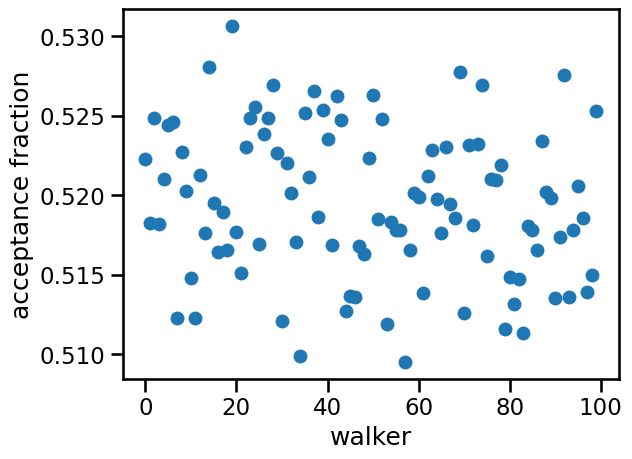

In [19]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [20]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[i]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 63.261
sig2 = 64.821
m = 65.125
s0 = 78.031
noise = 70.361


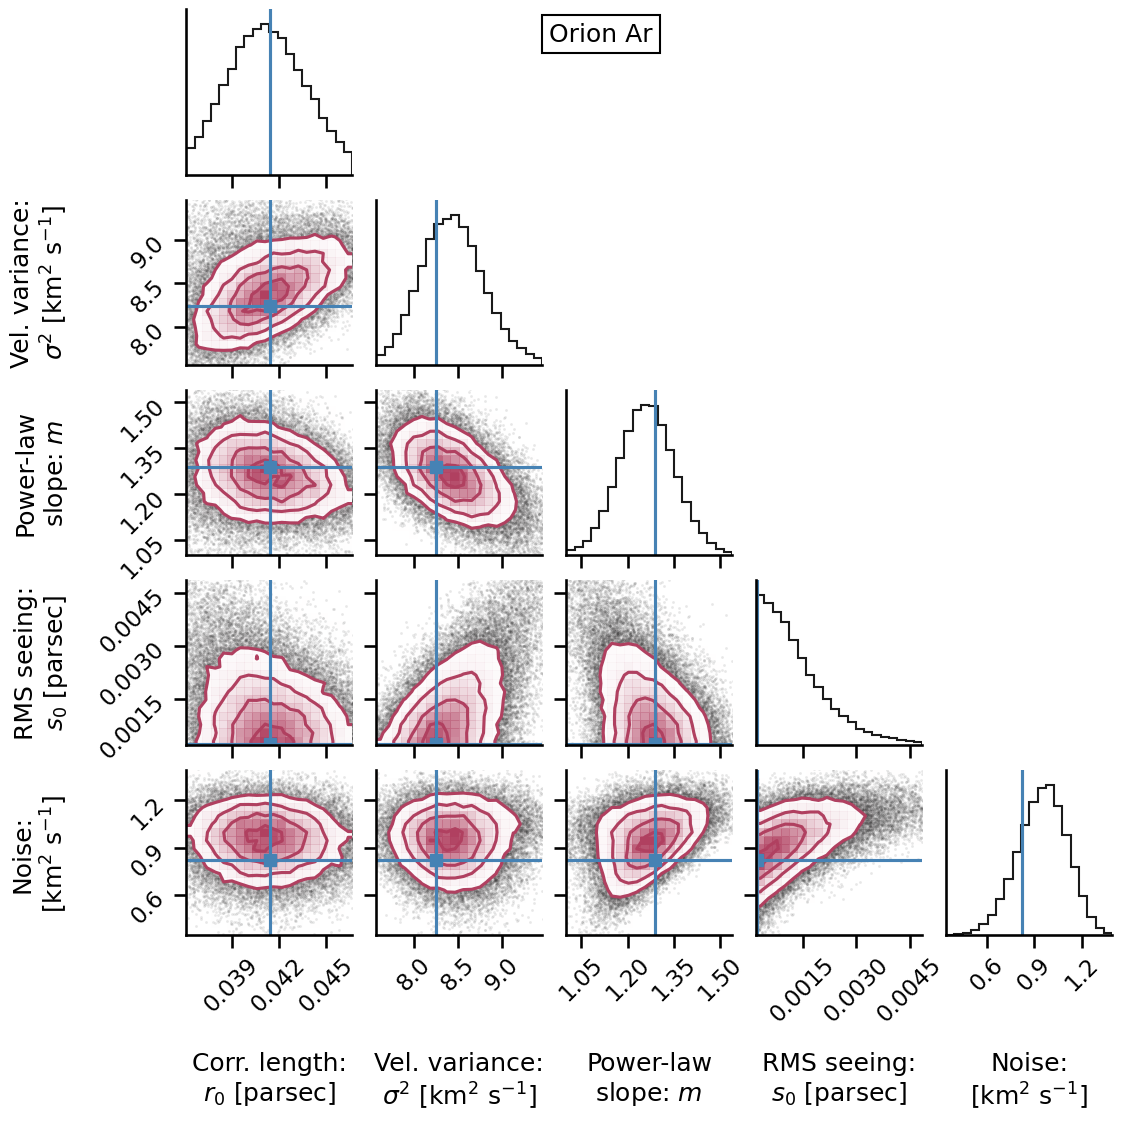

In [21]:

bplot.corner_plot(
    result_emcee, result, name_, data, data_ranges=[0.95, 0.99, 0.995, 0.997, 0.999]
)
# data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]

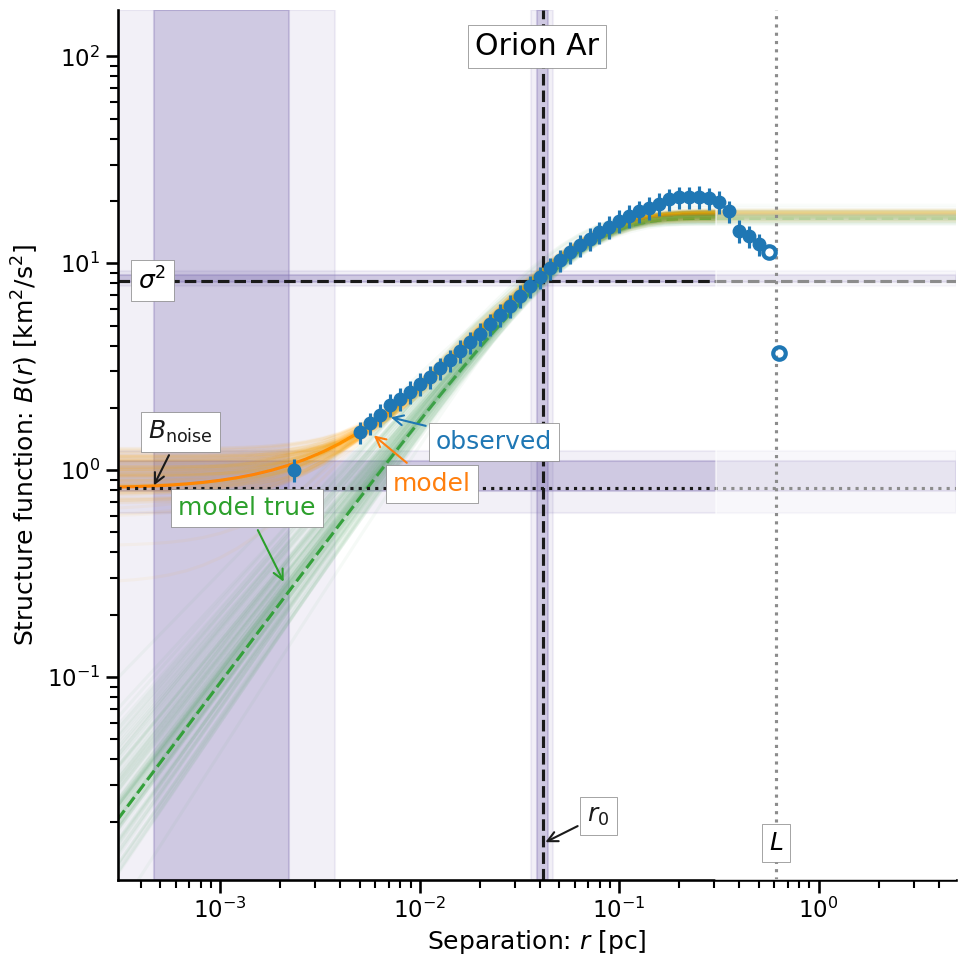

In [22]:
bplot.strucfunc_plot(
    result_emcee, result, r, B, to_fit, name_, data, box_size, large_scale
)

In [23]:
#bplot.strucfunc_plot(
#    result_emcee, result_emcee, r, B, to_fit, name, data, box_size, large_scale
#)

LM results

In [24]:
LM = {
    'sig2': [result.params['sig2'].value,result.params['sig2'].stderr],
    'r0': [result.params['r0'].value,result.params['r0'].stderr],
    'm' : [result.params['m'].value,result.params['m'].stderr],
    's0': [result.params['s0'].value,result.params['s0'].stderr],
    'noise' : [result.params['noise'].value,result.params['noise'].stderr]
}

In [25]:
LM

{'sig2': [8.24485846062363, 10.463631678708833],
 'r0': [0.041475460177736706, 0.0057518823931865465],
 'm': [1.2879720274648583, 0.5008562804431316],
 's0': [0.0002227581130711039, 0.0801849562688942],
 'noise': [0.8208747250030117, 11.182447838070518]}

MCMC results

In [26]:
MCMC = {
    'sig2': [result_emcee.params['sig2'].value,result_emcee.params['sig2'].stderr],
    'r0': [result_emcee.params['r0'].value,result_emcee.params['r0'].stderr],
    'm' : [result_emcee.params['m'].value,result_emcee.params['m'].stderr],
    's0': [result_emcee.params['s0'].value,result_emcee.params['s0'].stderr],
    'noise' : [result_emcee.params['noise'].value,result_emcee.params['noise'].stderr]
}

In [27]:
MCMC

{'sig2': [8.425813182922155, 0.3584022846388306],
 'r0': [0.041187310302541594, 0.002664093640835044],
 'm': [1.2623030621949716, 0.09068616304386967],
 's0': [0.00110582383493387, 0.0008782011029273467],
 'noise': [0.9561457313066317, 0.15655182785730654]}

MCMC 2 sigma confidence interval

In [28]:
sig2s2 = np.percentile(result_emcee.flatchain['sig2'],[2.5, 97.5])
r0s2 = np.percentile(result_emcee.flatchain['r0'],[2.5, 97.5])
ms2 = np.percentile(result_emcee.flatchain['m'],[2.5, 97.5])
s0s2 = np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])
b0s2 = np.percentile(result_emcee.flatchain['noise'],[2.5, 97.5])

In [29]:
sig2s2p = sig2s2[1]-result.params['sig2'].value
sig2s2m = result.params['sig2'].value-sig2s2[0]

r0s2p = r0s2[1]-result.params['r0'].value
r0s2m = result.params['r0'].value-r0s2[0]

ms2p = ms2[1]-result.params['m'].value
ms2m = result.params['m'].value-ms2[0]

s0s2p = s0s2[1]-result.params['s0'].value
s0s2m = result.params['s0'].value-s0s2[0]

b0s2p = b0s2[1]-result.params['noise'].value
b0s2m = result.params['noise'].value-b0s2[0]

MCMC 1 sigma confidence interval

In [30]:
sig2s1 = np.percentile(result_emcee.flatchain['sig2'],[16, 85])
r0s1 = np.percentile(result_emcee.flatchain['r0'],[16, 85])
ms1 = np.percentile(result_emcee.flatchain['m'],[16, 85])
s0s1 = np.percentile(result_emcee.flatchain['s0'],[16, 85])
b0s1 = np.percentile(result_emcee.flatchain['noise'],[16, 85])

In [31]:
sig2s1p = sig2s1[1]-result.params['sig2'].value
sig2s1m = result.params['sig2'].value-sig2s1[0]

r0s1p = r0s1[1]-result.params['r0'].value
r0s1m = result.params['r0'].value-r0s1[0]

ms1p = ms1[1]-result.params['m'].value
ms1m = result.params['m'].value-ms1[0]

s0s1p = s0s1[1]-result.params['s0'].value
s0s1m = result.params['s0'].value-s0s1[0]

b0s1p = b0s1[1]-result.params['noise'].value
b0s1m = result.params['noise'].value-b0s1[0]

LM + MCMC 2 sigma

In [32]:
results_2sig = {
    'sig2': [result.params['sig2'].value,sig2s2p,sig2s2m],
    'r0': [result.params['r0'].value,r0s2p,r0s2m],
    'm' : [result.params['m'].value,ms2p,ms2m],
    's0': [result.params['s0'].value,s0s2p,s0s2m],
    'noise' : [result.params['noise'].value,b0s2p,b0s2m] 
    
}

In [33]:
results_2sig

{'sig2': [8.24485846062363, 0.9594635183904963, 0.48199840606909294],
 'r0': [0.041475460177736706, 0.005216467742165873, 0.005364915897660978],
 'm': [1.2879720274648583, 0.1607651486169861, 0.205050135979701],
 's0': [0.0002227581130711039, 0.0035354613478120528, -1.6765280085663233e-05],
 'noise': [0.8208747250030117, 0.4143444769869449, 0.1977687585100285]}

In [34]:
results_1sig = {
    'sig2': [result.params['sig2'].value,sig2s1p,sig2s1m],
    'r0': [result.params['r0'].value,r0s1p,r0s1m],
    'm' : [result.params['m'].value,ms1p,ms1m],
    's0': [result.params['s0'].value,s0s1p,s0s1m],
    'noise' : [result.params['noise'].value,b0s1p,b0s1m] 
    
}

In [35]:
results_1sig

{'sig2': [8.24485846062363, 0.5640264706540528, 0.16528783171427364],
 'r0': [0.041475460177736706, 0.0025575112016364143, 0.0028692327214127414],
 'm': [1.2879720274648583, 0.06908246812570007, 0.115131727780319],
 's0': [0.0002227581130711039, 0.0020495709228257235, -0.0002449687411930159],
 'noise': [0.8208747250030117, 0.29013368467515566, 0.02783283569690742]}

Previous SF results and obs

In [36]:
#observations ={
#    'sb':data_in['VF']['sb'],
#    'vv':data_in['VF']['vv'],
 #   'ss':data_in['VF']['ss']   
#}

In [37]:
properties = {
    'pix'      : data_in['pix'],
    'pc'       : data_in['pc'],
    'box_size' : data_in['box_size'],
    's0'       : data_in['s0'],
    'sig2'     : data_in['sig2'],
}

preres = {
    'sig2'     : data_in['sig2'],
}

In [38]:
fit_results = {
    'name'         : name,
    'results_1sig' : results_1sig,
    'results_2sig' : results_2sig,
    'LM'           : LM,
    'MCMC'         : MCMC,
    'properties'   : properties,
    'B'            : B,
    'r'            : r,
    'preres'       : preres,
     'SFresults'   : data_in['SF'],
#   'observations' : observations    
}

In [39]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [40]:
jsonfilename = name +".json"
with open(RESULTS_DIR / jsonfilename, "w") as f:
    json.dump(fit_results, fp=f, indent=3, cls=MyEncoder)

In [41]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 257.49030923843384 seconds ---


In [42]:
#!jupyter nbconvert --to script --no-prompt ci-MUSE-Dor-H.ipynb